In [6]:
import utils
import matlab.engine
import dataset
import lstm_model

cfg = utils.Config(
    num_rx_antennas=1,
    num_tx_antennas=32,
    num_subcarriers=80,
    train_test_split=0.8,
    data_root="../data/dataset1",
    reduce_pca_overhead=False,
    # total_bits=  @Ibrahim change the bits here
    # duplicate_data=1,
    # data_snr=-1
)


dataset.combine_time_series_paths(
    "../data/dataset2",
    list(range(33)),
    2.5e9,
    "train_set.pickle"
)
dataset.combine_time_series_paths(
    "../data/dataset2",
    list(range(34, 40)),
    2.5e9,
    "test_set.pickle"
)

train_set = dataset.dataset_from_path("../data/dataset2/train_set.pickle", cfg)
test_set = dataset.dataset_from_path("../data/dataset2/test_set.pickle", cfg)
matlab = matlab.engine.start_matlab()
refModel = lstm_model.FullLSTMModel(cfg, matlab)

Saving files to  ../data/dataset2/train_set.pickle
Number of samples (14320, 1, 32, 1, 80)
Saving files to  ../data/dataset2/test_set.pickle
Number of samples (2655, 1, 32, 1, 80)
This is the LSTM


In [7]:
refModel.fit(train_set)

Fitting the PCA
Fitting the LSTM


/Users/dziper/opt/anaconda3/envs/csi/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0103
Epoch 2/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0098
Epoch 3/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0097
Epoch 4/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0097
Epoch 5/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0095
Epoch 6/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0096
Epoch 7/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0094
Epoch 8/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0093
Epoch 9/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0094
Epoch 10/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0094
Epoch 11/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0093
Epoch 12/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0093
Epoch 13/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0092
Epoch 14/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0092
Epoch 15/30
895/895 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - lo

  0%|          | 0/13 [00:00<?, ?it/s]

In [8]:
# Downlink
compressed_error, X_test = refModel.process(test_set)

# Uplink
predicted_csis, ul_pred_zdl = refModel.decode(compressed_error, X_test)

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Assessing performance...
Plotting results...


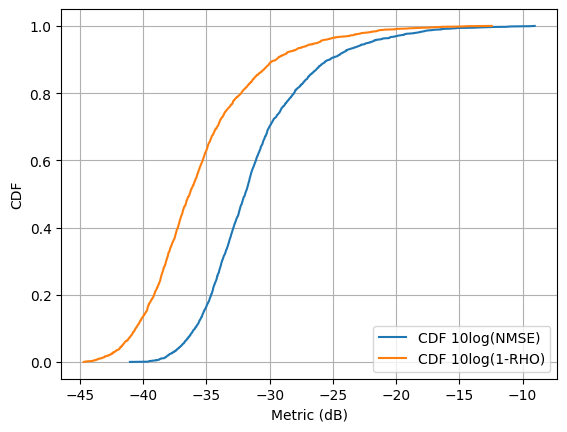

In [10]:
utils.reference_nmse_rho_test("lstm_plot", test_set.csi_samples[cfg.predictor_window_size:], predicted_csis)

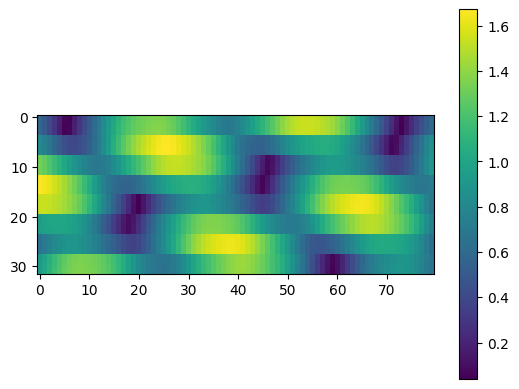

<Figure size 640x480 with 0 Axes>

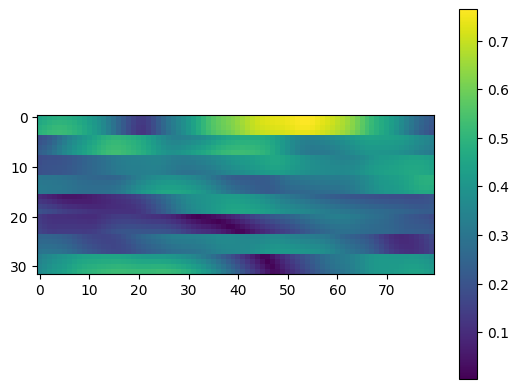

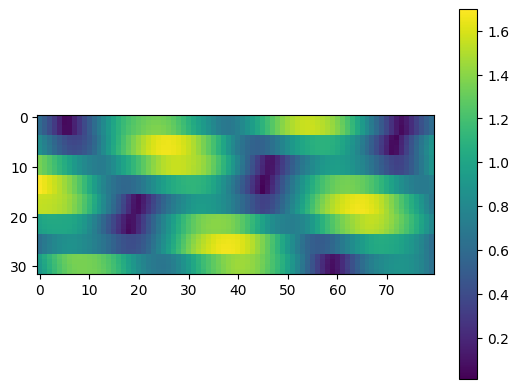

In [13]:
import matplotlib.pyplot as plt
import numpy as np

idx = 15

def plot_single_zdl(zdl, pca):
    plt.figure()
    zdl = np.expand_dims(zdl, axis=0)
    recovered = pca.decode(zdl)
    plt.imshow(np.squeeze(np.abs(recovered)))
    
plt.imshow(np.squeeze(np.abs(test_set.csi_samples[cfg.predictor_window_size + idx])))
plt.colorbar()
plt.figure()
plot_single_zdl(ul_pred_zdl[idx], refModel.pca)
plt.colorbar()

plt.figure()

plt.imshow(np.squeeze(np.abs(predicted_csis[idx])))
plt.colorbar()

